In [3]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
from IPython.display import display

## Section 1: Mise en place

In [4]:
# Import data - I saved datast on my desktop
d = pd.read_csv('H:/Desktop/US_Chronic_Disease_Indicators__CDI.csv', low_memory=False)

### Questions of interest

In [36]:
fields = ['YearEnd', 'LocationAbbr', 'LocationDesc',
          'DataSource', 'TopicID', 'DataValueAlt',
          'QuestionID', 'Question', 'DataValueUnit',
          'DataValueTypeID', 'DataValueType', 'StratificationCategoryID1',
          'StratificationCategory1', 'Stratification1']


drill_ques_text = pd.Series({'amputation': 'Amputation of a lower extremity attributable to diabetes',
                   'bp': 'Prevalence of high blood pressure among adults aged >= 18 years with diagnosed diabetes',
                   'ldl': 'Prevalence of high cholesterol among adults aged >= 18 years with diagnosed diabetes',
                   'mort': 'Mortality due to diabetes reported as any listed cause of death',
                   'dentist': 'Visits to dentist or dental clinic among adults aged >= 18 years with diagnosed diabetes',
                   'edu': 'Adults with diagnosed diabetes aged >= 18 years who have taken a diabetes self-management course',
                   'eye': 'Dilated eye examination among adults aged >= 18 years with diagnosed diabetes',
                   'fingerstick': 'Glycosylated hemoglobin measurement among adults aged >= 18 years with diagnosed diabetes',
                   'mort_keto': 'Mortality with diabetic ketoacidosis reported as any listed cause of death',
                             'prev': 'Prevalence of diagnosed diabetes among adults aged >= 18 years'}, name='Question')

drill_ques = pd.DataFrame()
drill_ques['Question'] = drill_ques_text.sort_values()
ques = d.loc[d.TopicID=='DIA'][['Question', 'QuestionID']].drop_duplicates().set_index('Question')
drill_ques = drill_ques.join(ques, on='Question')
# drill_ques

### Creating reference data

In [6]:
# Reference data for overall diabetes prevalence, BRFSS, 2011-2016
overall = {'qid': 'DIA2_1', 'data_valuetype_id': 'AGEADJPREV',
                    'strat': 'OVERALL',
                     'alias': 'overall_diabetes'}

In [7]:
# BRFSS diabetes prevalence in adults
mdata = pd.DataFrame(columns=['qid', 'data_valuetype_id', 'strat', 'range_min', 'range_max', 'alias'])
mdata = mdata.append(pd.Series(overall, name='overall_diabetes'))

In [8]:
overall_years = d.loc[(d['QuestionID']==mdata.iloc[0]['qid']) &
                      (d['StratificationCategoryID1']==mdata.iloc[0]['strat']) &
                      (d['DataValueTypeID']==mdata.iloc[0]['data_valuetype_id'])]\
    .YearEnd.drop_duplicates().sort_values()
mdata.loc[mdata['alias']=='overall_diabetes', 'range_min'] = min(overall_years)
mdata.loc[mdata['alias']=='overall_diabetes', 'range_max'] = max(overall_years)

In [9]:
mid_women = pd.Series({'qid': 'DIA2_2', 
             'data_valuetype_id': 'CRDPREV',
             'strat': 'OVERALL', 'alias': 'mid_women'})
mdata = mdata.append(pd.Series(mid_women, name='mid_women'))

In [10]:
wom_years = d.loc[(d['QuestionID']==mid_women['qid']) & 
                  (d['DataValueTypeID']==mid_women['data_valuetype_id'])]\
    .YearEnd.drop_duplicates().sort_values()
mdata.loc[mdata['alias']=='mid_women', 'range_min'] = min(wom_years)
mdata.loc[mdata['alias']=='mid_women', 'range_max'] = max(wom_years)

### Formatting parameters for visualizations

In [46]:
# Formatting variables for matplotlib
lab_font = '16'
tick_font = '14'
lab_pad = 20
title_font = str(int(lab_font) + 2)

## Section 2: Age-adjusted diabetes prevalence trends in the United States, 2011-2016

### Data preparation

In [11]:
# Create data for prevalence boxplots

# Drop columns that will not be used as indices or in the visualization
od = d.loc[(d['QuestionID']==mdata.loc['overall_diabetes', 'qid']) &
           (d['DataValueTypeID']==mdata.loc['overall_diabetes', 'data_valuetype_id']) &
           (d['StratificationCategoryID1']==mdata.loc['overall_diabetes', 'strat'])]

# Filter out VI and US for data quality. See data preparation below.
od = od.loc[~od['LocationAbbr'].isin(['VI', 'US'])]

# # Create pivot table. Since plt.boxplot() interprets rows as
# # data series, each year has to be a single row, meaning each
# # state/territory needs to be its own column.
od = od[['LocationAbbr', 'YearEnd', 'DataValueAlt']]

box_data=od.pivot(index='YearEnd', columns='LocationAbbr')

In [12]:
prev_locations = d.loc[(d['QuestionID']==mdata.loc['overall_diabetes', 'qid']) &
     (d['DataValueTypeID']==mdata.loc['overall_diabetes', 'data_valuetype_id']) &
     (d['StratificationCategoryID1']==mdata.loc['overall_diabetes', 'strat'])].LocationDesc.drop_duplicates().sort_values()

### Calculations and hypothesis testing

#### National age-adjusted median diabetes prevalence, 2011-2016

In [38]:
# Median diabetes prevalence for 2011-2016
d.loc[(d.QuestionID==mdata.loc['overall_diabetes', 'qid']) &
     (d.LocationAbbr=='US') &
     (d.DataValueTypeID==mdata.loc['overall_diabetes', 'data_valuetype_id']) &
     (d.StratificationCategoryID1=='OVERALL'),
     ['YearEnd', 'DataValueAlt']].sort_values('YearEnd')

,YearEnd,DataValueAlt
224223,2011,9.0
166548,2012,9.0
375448,2013,8.9
300758,2014,9.1
97588,2015,9.1
30214,2016,9.5


#### National diabetes prevalence paried t-test, 2011 to 2016

In [39]:
# Independent ttest (this is actually a problem because these samples aren't independent)
tpair = stats.ttest_rel(box_data.loc[2011], box_data.loc[2016])

print('Diabetes prevalence paired t-test p-value: {0}'.format(np.around(tpair[1], 4)))

Diabetes prevalence paired t-test p-value: 0.0002


### Visualizations

#### Boxplot: Diabetes prevalence trends across states/ territories, 2011-2016

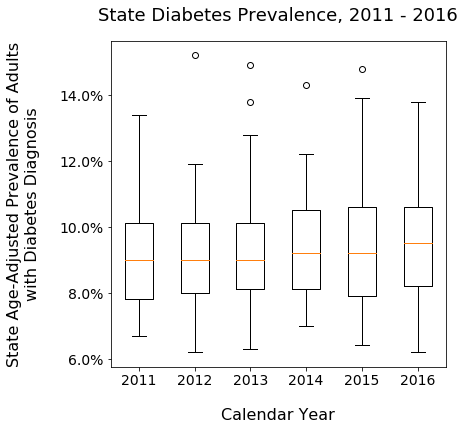

In [47]:
# Boxplot visualization
fig, ax = plt.subplots(figsize = (6, 6))

ax.boxplot(box_data)

# X-axis formatting
ax.tick_params(labelsize=tick_font)
plt.xticks(range(1,len(box_data.index)+1, 1), labels=box_data.index)
plt.xlabel("Calendar Year", fontsize=lab_font, labelpad=lab_pad)

# Y-axis formatting
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x}%"))
plt.ylabel("State Age-Adjusted Prevalence of Adults\nwith Diabetes Diagnosis", fontsize=lab_font, labelpad=lab_pad)

# Title formatting
plt.title("State Diabetes Prevalence, {0} - {1}".format(mdata.loc['overall_diabetes', 'range_min'],
                                                       mdata.loc['overall_diabetes', 'range_max']),
          pad=lab_pad,
          fontdict={'fontsize': str(int(lab_font) + 2)})



plt.show()

#### Lineplot: Diabetes prevalence by state, 2011-2016

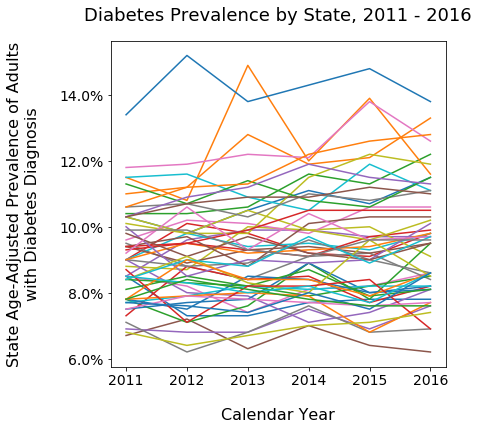

In [48]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(box_data)

# X-axis formatting
ax.tick_params(labelsize=tick_font)
plt.xlabel("Calendar Year", fontsize=lab_font, labelpad=lab_pad)

# Y-axis formatting
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x}%"))
plt.ylabel("State Age-Adjusted Prevalence of Adults\nwith Diabetes Diagnosis", fontsize=lab_font, labelpad=lab_pad)

# Title formatting
plt.title("Diabetes Prevalence by State, {0} - {1}".format(mdata.loc['overall_diabetes', 'range_min'],
                                                       mdata.loc['overall_diabetes', 'range_max']),
          pad=lab_pad,
          fontdict={'fontsize': str(int(lab_font) + 2)})

plt.show()

## Section 3: Diabetes-related mortality, 2010-2014

### Data preparation

In [40]:
pre_mort = d.loc[(d.QuestionID==drill_ques.loc['mort', 'QuestionID']) &
                 (d.DataValueTypeID=='AGEADJRATE') &
                 (d.Stratification1=='Overall') &
                (d.LocationAbbr!='US')]

In [41]:
# # Testing for null values
# pm_na = pre_mort[['YearEnd', 'LocationDesc', 'DataValueAlt']].pivot(index='LocationDesc', columns='YearEnd').DataValueAlt
# pm_na.isna().apply(sum)

In [42]:
# Discover data value unit (e.g., percenve, cases per 100,000, etc.)
# pre_mort.DataValueUnit.drop_duplicates()
# Data value units are cases per 100,000 population for mortality where diabetes exists as a cause of death,
# though not necessarily the PRIMARY cause of death

In [43]:
# Drop columns not used in visualization
mort = pre_mort[['YearEnd', 'LocationDesc', 'DataValueAlt']]

# Pivot for box plot
mort_piv = mort.pivot(index='YearEnd', columns='LocationDesc')

### Calculations and hypothesis testing

#### Diabetes-related mortality median

In [47]:
# Calculating median mortality in 2010 and 2014
med10 = mort_piv.iloc[0].median()
med14 = mort_piv.iloc[len(mort_piv)-1].median()

print('Diabetes-related median, {0}: {1}'.format(np.round(pre_mort.YearEnd.min(), 0), np.round(med10, 1)))
print('Diabetes-related median, {0}: {1}'.format(np.round(pre_mort.YearEnd.max(), 0), np.round(med14, 1)))

Diabetes-related median, 2010: 69.3
Diabetes-related median, 2014: 65.0


#### Paired t-test

In [110]:
ttest = stats.ttest_rel(mort_piv.iloc[0], mort_piv.iloc[len(mort_piv)-1])
print('Diabetes-related mortality p-value: {}'.format(np.around(ttest[1], 3)))

Diabetes-related mortality p-value: 0.003


### Visualizations

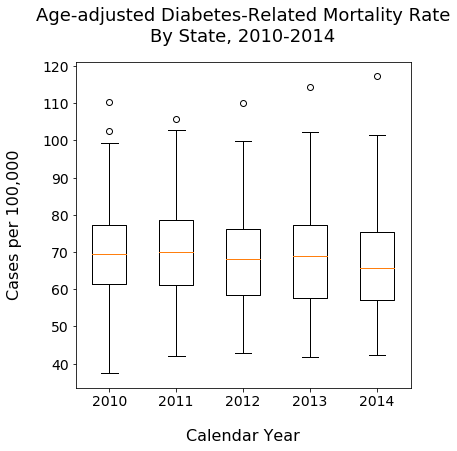

In [67]:
fig, ax = plt.subplots(figsize=(6,6))

ax.boxplot(mort_piv)

# x-axis
ax.tick_params(labelsize=tick_font)
plt.xticks(range(1,len(mort_piv.index)+1, 1), labels=mort_piv.index)
plt.xlabel("Calendar Year", fontsize=lab_font, labelpad=lab_pad)

# y-axis
plt.ylabel("Cases per 100,000", fontsize=lab_font, labelpad=lab_pad)

# title
plt.title("Age-adjusted Diabetes-Related Mortality Rate\nBy State, 2010-2014", pad=lab_pad,
          fontdict={'fontsize': str(int(lab_font) + 2)})

plt.show()

## Section 4: Puerto Rico Highlight

### Data preparation

#### Highest Diabetes Disease Burden by State - crude prevalence

In [17]:
cprev_pre = d.loc[(d.QuestionID==mdata.loc['overall_diabetes', 'qid']) &
                (d.Stratification1=='Overall') &
                (d.DataValueTypeID=='CRDPREV') &
                 (d.LocationAbbr != 'US')]

cprev = cprev_pre.loc[cprev_pre.YearEnd==cprev_pre.YearEnd.max(),
                     ['LocationDesc', 'DataValueAlt']].sort_values('DataValueAlt', ascending=False)

In [18]:
cp_min = cprev_pre.DataValueAlt.min()
cp_max = cprev_pre.DataValueAlt.max()

#### Crude prevalence by gender in Puerto Rico

In [19]:
pr = d[fields].loc[(d.QuestionID.isin(drill_ques['QuestionID'])) &
                   (d['LocationAbbr']=='PR')]

In [20]:
# Stratification and values
pr_vt = pr.loc[pr['LocationAbbr']=='PR']
# dt.join(, on='QuestionID', rsuffix='_r')
# pr_vt

In [21]:
# How many ways do we have to slice  age-adjusted prevalence?

pr_sex = pr.loc[(pr.QuestionID==mdata.loc['overall_diabetes', 'qid']) &
               (pr.DataValueTypeID==mdata.loc['overall_diabetes', 'data_valuetype_id']) &
               pr.StratificationCategoryID1.isin(['OVERALL', 'GENDER'])][
    ['YearEnd', 'Stratification1', 'DataValueAlt']]

pr_sex_line = pr_sex.sort_values(['YearEnd', 'Stratification1']).pivot(index='YearEnd', columns='Stratification1')

In [22]:
pr_dt = d.loc[(d['LocationAbbr']=='PR') &
     (d['QuestionID']==mdata.loc['overall_diabetes', 'qid']) &
     (d['StratificationCategoryID1'].isin(['GENDER', 'OVERALL'])),
      ['YearEnd', 'DataValueTypeID', 'Stratification1', 'DataValueAlt']].sort_values('YearEnd')

In [23]:
sex_flds = ['YearEnd', 'Stratification1', 'DataValueAlt']

d1 = pr_dt.loc[pr_dt.DataValueTypeID=='CRDPREV',
              sex_flds].pivot(index='YearEnd', columns='Stratification1').DataValueAlt

d2 = pr_dt.loc[pr_dt.DataValueTypeID=='AGEADJPREV',
          sex_flds].pivot(index='YearEnd', columns='Stratification1').DataValueAlt

### Visualizations

#### Barplot: Crude diabetes prevalence by state, 2016

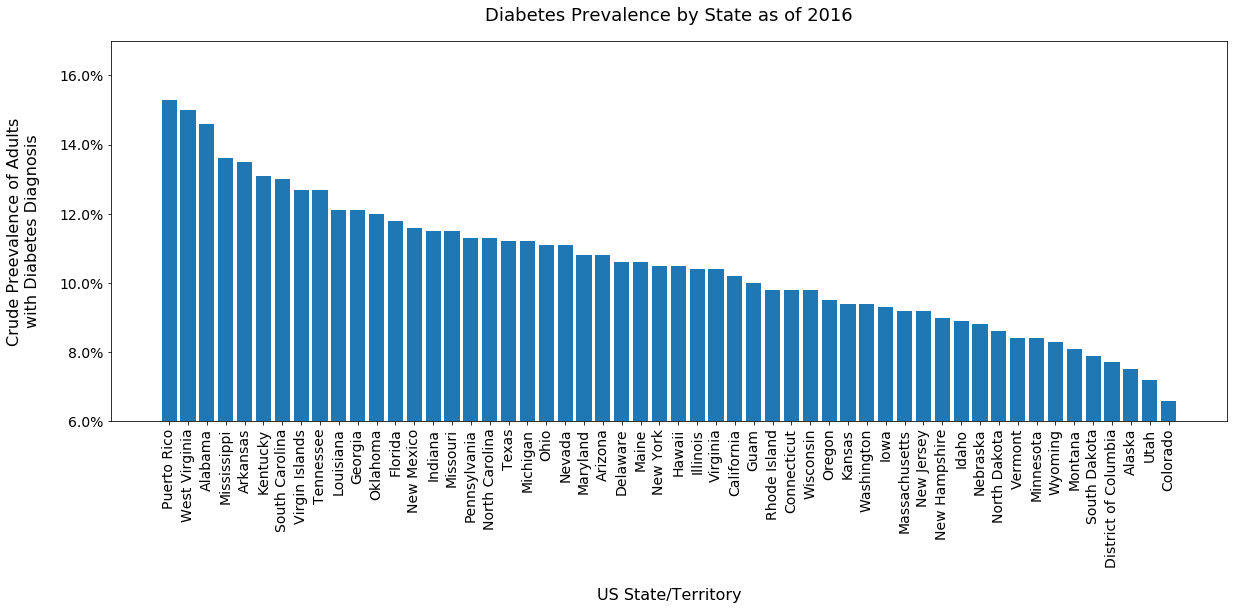

In [49]:
# Barplot: highest crude diabetes prevalence by state/territory
fig, ax = plt.subplots(figsize = (20, 7))
ax.bar(cprev.LocationDesc, cprev.DataValueAlt)

# X-axis formatting
ax.tick_params(labelsize=tick_font)
plt.xticks(rotation=90)
plt.xlabel("US State/Territory", fontsize=lab_font, labelpad=lab_pad)

# Y-axis formatting
ax.set_ylim([np.floor(cp_min), np.ceil(cp_max)])
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x}%"))
plt.ylabel("Crude Preevalence of Adults\nwith Diabetes Diagnosis", fontsize=lab_font, labelpad=lab_pad)

# Title formatting
plt.title("Diabetes Prevalence by State as of {}".format(mdata.loc['overall_diabetes', 'range_max']),
          pad=lab_pad,
          fontdict={'fontsize': str(int(lab_font) + 2)})

plt.show()

#### Lineplot: Crude diabetes prevalence in Puerto Rico by gender, 2011-2016

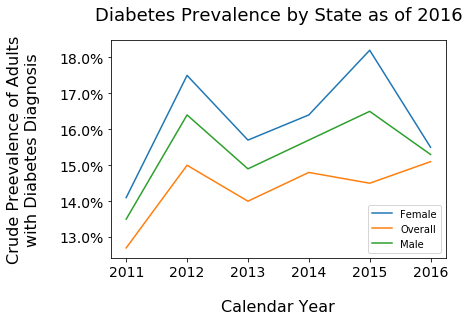

In [50]:
# Visualizing gender difference

fig, ax = plt.subplots()
ax.plot(d1)
ax.legend(['Female', 'Overall', 'Male'])

# X-axis formatting
ax.tick_params(labelsize=tick_font)
plt.xlabel("Calendar Year", fontsize=lab_font, labelpad=lab_pad)

# Y-axis formatting
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x}%"))
plt.ylabel("Crude Preevalence of Adults\nwith Diabetes Diagnosis", fontsize=lab_font, labelpad=lab_pad)

# Title formatting
plt.title("Diabetes Prevalence by State as of {}".format(mdata.loc['overall_diabetes', 'range_max']),
          pad=lab_pad,
          fontdict={'fontsize': str(int(lab_font) + 2)})

plt.show()